# 1) Simulated IMU signals

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.signal import butter, sosfiltfilt

In [12]:
def get_simulated_IMU_measurements(segment_orientation_position, f_sample=100, seq="XYZ"):    
    # Restructure
    rot_vecs = segment_orientation_position[:, 0:3] # in radians
    translations = segment_orientation_position[:, 3:6] # in meters
    nan_mat = np.empty((3, 3))
    nan_mat[:] = np.nan

    # Change orientation representation, rotation vector to rotation matrices
    n_pts = np.shape(rot_vecs)[0]
    rot_matrices = np.zeros((n_pts, 3, 3))
    inv_rot_matrices = np.zeros((n_pts, 3, 3))

    for i in np.arange(n_pts):
        rotation = Rotation.from_rotvec(rot_vecs[i, :])
        rot_matrices[i, :, :] = rotation.as_matrix()
        inv_rot_matrices[i, :, :] = np.linalg.inv(rot_matrices[i, :, :])
        # inv_rot_matrices[i, :, :] = rotation.inv().as_matrix()

    # Calculate rotational velocity and linear acceleration a measured from the segment frame of reference
    delta_rot_matrices = np.zeros((n_pts-1, 3, 3))
    delta_euler_angles = np.zeros((n_pts-1, 3))

    accelerations = np.diff(translations, n=2, axis=0)
    accelerations *= f_sample**2
    
    gravity = np.concatenate((np.zeros((n_pts-2, 2)), np.ones((n_pts-2, 1))*9.81), axis=1)
    accelerations += gravity

    # Loop
    for i in np.arange(n_pts-2):
        delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], inv_rot_matrices[i, :, :])
        try:
            rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
            delta_euler_angles[i, :] = np.matmul(inv_rot_matrices[i, :, :], rotation.as_euler(seq).reshape((-1, 1))).reshape((1, -1))
            accelerations[i, :] = np.matmul(inv_rot_matrices[i, :, :], accelerations[i, :].reshape((-1, 1))).reshape((1, -1))
        except (np.linalg.LinAlgError):
            delta_euler_angles[i, :] = np.nan
            accelerations[i, :] = np.nan

    # One extra point for rotational velocities
    i = n_pts-2
    delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], inv_rot_matrices[i, :, :])
    try:
        rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
        delta_euler_angles[i, :] = np.matmul(inv_rot_matrices[i, :, :], rotation.as_euler(seq).reshape((-1, 1))).reshape((1, -1))
    except (np.linalg.LinAlgError):
        delta_euler_angles[i, :] = np.nan

    delta_euler_angles *= f_sample
    
    return delta_euler_angles, accelerations

In [13]:
# Simulated IMU features
dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject17/Session1_Proc_Trn/Subj17 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - GloAng.csv"
df = pd.read_csv(dev_file)

cols_R = ["R_Foot_RX", "R_Foot_RY", "R_Foot_RZ"]
cols_T = ["R_Foot_TX", "R_Foot_TY", "R_Foot_TZ"]
f_sample = 100
seq = "XYZ"

rot_vec = df[cols_R].to_numpy()
rot_vec = rot_vec * (np.pi/180) # to radians
translations = df[cols_T].to_numpy()
translations = translations * 0.001 # to meters

segment_orientation_position = np.concatenate((rot_vec, translations), axis=1)
delta_euler_angles, accelerations = get_simulated_IMU_measurements(segment_orientation_position, f_sample=f_sample, seq=seq)

# Reference IMU features
ref_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject17/Session1_Proc_Trn/Subj17 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - MotNorm.csv"
df_ref = pd.read_csv(ref_file)
delta_euler_angles_ref = df_ref[["RANGX", "RANGY", "RANGZ"]].to_numpy()
accelerations_ref = df_ref[["RACCX", "RACCY", "RACCZ"]].to_numpy() * 9.81 # from g to m/s2

C:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [16]:
# Correlations and comparative plot
R2_ang = np.corrcoef(accelerations[800:1250, :], y=accelerations_ref[800:1250, :], rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

ref_filtered = accelerations_ref[800:1250, :]
filter = butter(2, 6, btype='low', analog=False, output='sos', fs=f_sample)
ref_filtered_acc = sosfiltfilt(filter, ref_filtered, axis=0)
R2_ang = np.corrcoef(accelerations[800:1250, :], y=ref_filtered_acc, rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

R2_ang = np.corrcoef(delta_euler_angles[800:1250, :], y=delta_euler_angles_ref[800:1250, :], rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

ref_filtered = delta_euler_angles_ref[800:1250, :]
filter = butter(2, 6, btype='low', analog=False, output='sos', fs=f_sample)
ref_filtered_ang = sosfiltfilt(filter, ref_filtered, axis=0)
R2_ang = np.corrcoef(delta_euler_angles[800:1250, :], y=ref_filtered_ang, rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

%matplotlib qt

### Define style
title_size = 50
title_weight = "bold"
titlepad = 50

ylabel_size = 35
ylabel_weight = "normal"
ylabelpad_1 = 90
ylabelpad_2 = 90
ylabelpad_3 = 90
char_comp = -12

xlabel_size = 35
xlabel_weight = "normal"
xlabelpad = 25

tick_size = 20

linestyle = "-"
linewidth = 4
linestyle_ref = "--"
linewidth_ref = 4

legend_size = 20

def set_font_size_ticks(axs, size):
    xticks = axs.get_xticks()
    xticks[0] = -0.3
    xticks[-1] = 4.8
    xticklabels = axs.get_xticklabels()
    xticklabels[0] = None
    xticklabels[-1] = None
    yticks = axs.get_yticks()
    yticklabels = axs.get_yticklabels()
    axs.set_xticks(xticks, labels=xticklabels, size=size)
    axs.set_yticks(yticks, labels=yticklabels, size=size)
    return

def get_nchar_yticks(axs):
    yticklabels = axs.get_yticklabels()
    nchar = 0
    for label in yticklabels:
        nchar_i = len(label.get_text())
        if nchar_i > nchar:
            nchar = nchar_i
        else:
            pass
    return nchar

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
x_axis = np.linspace(0, 4.5, num=450)

# Accelerations
axs[0, 0].yaxis.tick_left()
axs[0, 0].yaxis.set_label_position("left")
axs[1, 0].yaxis.tick_left()
axs[1, 0].yaxis.set_label_position("left")
axs[2, 0].yaxis.tick_left()
axs[2, 0].yaxis.set_label_position("left")

axs[0, 0].plot(x_axis, accelerations[800:1250, 0], label="acc_x", c=(0.7, 0.1, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[1, 0].plot(x_axis, accelerations[800:1250, 1], label="acc_y", c=(0.1, 0.7, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[2, 0].plot(x_axis, accelerations[800:1250, 2], label="acc_z", c=(0.1, 0.1, 0.7), linestyle=linestyle, linewidth=linewidth)
axs[0, 0].plot(x_axis, ref_filtered_acc[:, 1], label="acc_x_ref", c=(0.7, 0.1, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[1, 0].plot(x_axis, ref_filtered_acc[:, 2], label="acc_y_ref", c=(0.1, 0.7, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[2, 0].plot(x_axis, ref_filtered_acc[:, 0], label="acc_z_ref", c=(0.1, 0.1, 0.7), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)

# Angular velocities
axs[0, 1].yaxis.tick_right()
axs[0, 1].yaxis.set_label_position("right")
axs[1, 1].yaxis.tick_right()
axs[1, 1].yaxis.set_label_position("right")
axs[2, 1].yaxis.tick_right()
axs[2, 1].yaxis.set_label_position("right")

axs[0, 1].plot(x_axis, delta_euler_angles[800:1250, 0], label="ang_x", c=(0.7, 0.1, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[1, 1].plot(x_axis, delta_euler_angles[800:1250, 1], label="ang_y", c=(0.1, 0.7, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[2, 1].plot(x_axis, delta_euler_angles[800:1250, 2], label="ang_z", c=(0.1, 0.1, 0.7), linestyle=linestyle, linewidth=linewidth)
axs[0, 1].plot(x_axis, ref_filtered_ang[:, 1], label="ang_x_ref", c=(0.7, 0.1, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[1, 1].plot(x_axis, ref_filtered_ang[:, 2], label="ang_y_ref", c=(0.1, 0.7, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[2, 1].plot(x_axis, ref_filtered_ang[:, 0], label="ang_z_ref", c=(0.1, 0.1, 0.7), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)


### Set labels and stuff
# Accelerations
axs[0, 0].set_title("Linear accelerations", size=title_size, weight=title_weight, pad=titlepad)
axs[0, 0].set_ylabel("Along x-axis [m/s2]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[0, 0])))
set_font_size_ticks(axs[0, 0], tick_size)
axs[0, 0].legend(fontsize=legend_size, loc="lower left")
axs[0, 0].grid()

axs[1, 0].set_ylabel("Along y-axis [m/s2]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[1, 0])))
set_font_size_ticks(axs[1, 0], tick_size)
axs[1, 0].legend(fontsize=legend_size, loc="lower left")
axs[1, 0].grid()

axs[2, 0].set_ylabel("Along z-axis [m/s2]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[2, 0])))
set_font_size_ticks(axs[2, 0], tick_size)
axs[2, 0].legend(fontsize=legend_size, loc="lower left")
axs[2, 0].grid()

# Angular velocities
axs[0, 1].set_title("Angular velocities", size=title_size, weight=title_weight, pad=titlepad)
axs[0, 1].set_ylabel("Around x-axis [rad/s]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[0, 1])))
set_font_size_ticks(axs[0, 1], tick_size)
axs[0, 1].legend(fontsize=legend_size, loc="upper right")
axs[0, 1].grid()

axs[1, 1].set_ylabel("Around y-axis [rad/s]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[1, 1])))
set_font_size_ticks(axs[1, 1], tick_size)
axs[1, 1].legend(fontsize=legend_size, loc="upper right")
axs[1, 1].grid()

axs[2, 1].set_ylabel("Around z-axis [rad/s]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[2, 1])))
set_font_size_ticks(axs[2, 1], tick_size)
axs[2, 1].legend(fontsize=legend_size, loc="upper right")
axs[2, 1].grid()


### Done!
plt.show()

0.34917165931727345 0.574848303964138 0.8626902167261018
0.4291852367494907 0.6639844948102083 0.9189076333802205
0.9652332291477504 0.6794417852511184 0.5414663653723101
0.9716239192657348 0.7289139231693763 0.5709741943965596


# 2) Comparison with other dataset

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.signal import butter, sosfiltfilt

In [11]:
# Load own data
own_data = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Reference trajectories/All subjects/Normal level walking - means.csv"
# own_data = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Reference trajectories/All subjects/Fast level walking - means.csv"
own_data_df = pd.read_csv(own_data)

ankle_angle = own_data_df["AnkleAnglesX"].to_numpy()
knee_angle = own_data_df["KneeAnglesX"].to_numpy()
hip_angle = own_data_df["HipAnglesX"].to_numpy()

ankle_torque = own_data_df["AnkleMomentX_filt"].to_numpy()/1000 # Nmm to Nm
knee_torque = own_data_df["KneeMomentX_filt"].to_numpy()/1000
hip_torque = own_data_df["HipMomentX_filt"].to_numpy()/1000

grf_x = own_data_df["GroundReactionForceX"].to_numpy()
grf_y = own_data_df["GroundReactionForceY"].to_numpy()
grf_z = own_data_df["GroundReactionForceZ"].to_numpy()

emg_ta = own_data_df["RMS TA"].to_numpy()
emg_gl = own_data_df["RMS GL"].to_numpy()
emg_vl = own_data_df["RMS VL"].to_numpy()
emg_bf = own_data_df["RMS BF"].to_numpy()

# Load reference data
ankle_angle_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_ankle_angles_V4.csv").to_numpy()
knee_angle_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_knee_angles_V4.csv").to_numpy()
hip_angle_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_hip_angles_V4.csv").to_numpy()

ankle_torque_ref = -pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_ankle_torques_V4.csv").to_numpy()
knee_torque_ref = -pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_knee_torques_V4.csv").to_numpy()
hip_torque_ref = -pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_hip_torques_V4.csv").to_numpy()

grf_x_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_grf_x_V4.csv").to_numpy()
grf_y_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_grf_y_V4.csv").to_numpy()
grf_z_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_grf_z_V4.csv").to_numpy()

emg_ta_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_emg_ta_V4.csv").to_numpy()
emg_gl_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_emg_gl_V4.csv").to_numpy()
emg_vl_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_emg_vl_V4.csv").to_numpy()
emg_bf_ref = pd.read_csv("C:/Users/robaeten/OneDrive - UGent/Documenten/Werk/Literatuur/datasets/Check ref 1/avg_emg_bf_V4.csv").to_numpy()

In [12]:
def spec_interp(data_in):
    n_old = 1000
    n_new = 100
    x_old = np.linspace(0, 1, num=n_old)
    x_new = np.linspace(0, 1, num=n_new)
    data_out = np.interp(x_new, x_old, data_in.squeeze())
    return data_out

In [13]:
# Resample to same size
ankle_angle_ref_rs = spec_interp(ankle_angle_ref)
knee_angle_ref_rs = spec_interp(knee_angle_ref)
hip_angle_ref_rs = spec_interp(hip_angle_ref)

ankle_torque_ref_rs = spec_interp(ankle_torque_ref)
knee_torque_ref_rs = spec_interp(knee_torque_ref)
hip_torque_ref_rs = spec_interp(hip_torque_ref)

grf_x_ref_rs = spec_interp(grf_x_ref)
grf_y_ref_rs = spec_interp(grf_y_ref)
grf_z_ref_rs = spec_interp(grf_z_ref)

emg_ta_ref_rs = spec_interp(emg_ta_ref)
emg_gl_ref_rs = spec_interp(emg_gl_ref)
emg_vl_ref_rs = spec_interp(emg_vl_ref)
emg_bf_ref_rs = spec_interp(emg_bf_ref)



Pearson correlation coefficient for the ankle angle: 0.9852


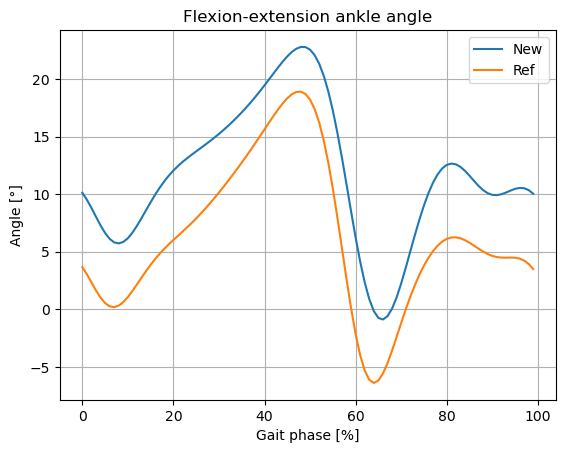



Pearson correlation coefficient for the knee angle: 0.9802


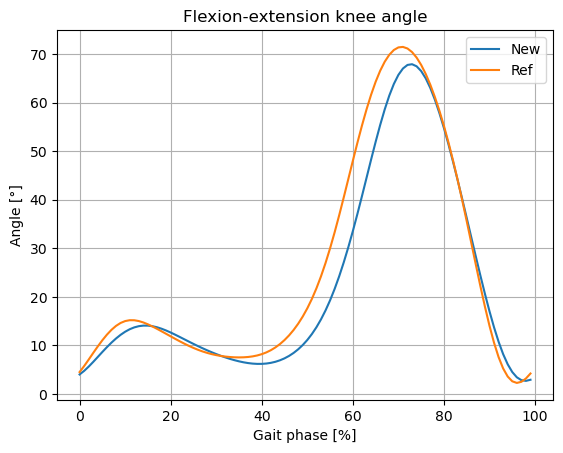



Pearson correlation coefficient for the hip angle: 0.986


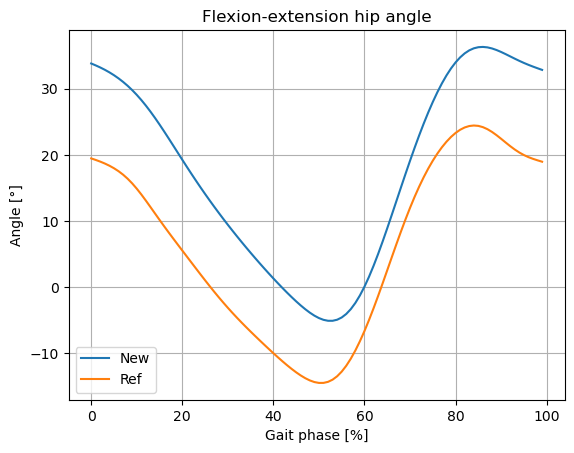

In [14]:
# Correlations and comparative plot, angles
%matplotlib inline
x_axis = np.linspace(0, 100, num=100, endpoint=False)

ankle_angle_corr = np.corrcoef(ankle_angle, y=ankle_angle_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the ankle angle: {ankle_angle_corr[0, 1]:.4g}")
plt.figure()
plt.title("Flexion-extension ankle angle")
plt.plot(x_axis, ankle_angle, label="New")
plt.plot(x_axis, ankle_angle_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Angle [°]")
plt.legend()
plt.grid()
plt.show()

knee_angle_corr = np.corrcoef(knee_angle, y=knee_angle_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the knee angle: {knee_angle_corr[0, 1]:.4g}")
plt.figure()
plt.title("Flexion-extension knee angle")
plt.plot(x_axis, knee_angle, label="New")
plt.plot(x_axis, knee_angle_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Angle [°]")
plt.legend()
plt.grid()
plt.show()

hip_angle_corr = np.corrcoef(hip_angle, y=hip_angle_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the hip angle: {hip_angle_corr[0, 1]:.4g}")
plt.figure()
plt.title("Flexion-extension hip angle")
plt.plot(x_axis, hip_angle, label="New")
plt.plot(x_axis, hip_angle_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Angle [°]")
plt.legend()
plt.grid()
plt.show()



Pearson correlation coefficient for the ankle torque: 0.9746


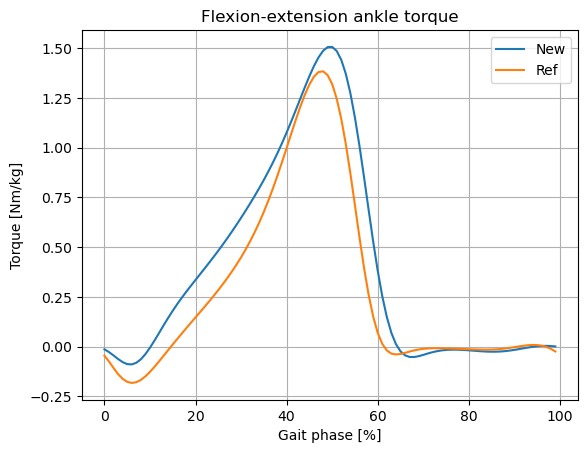



Pearson correlation coefficient for the knee torque: 0.7968


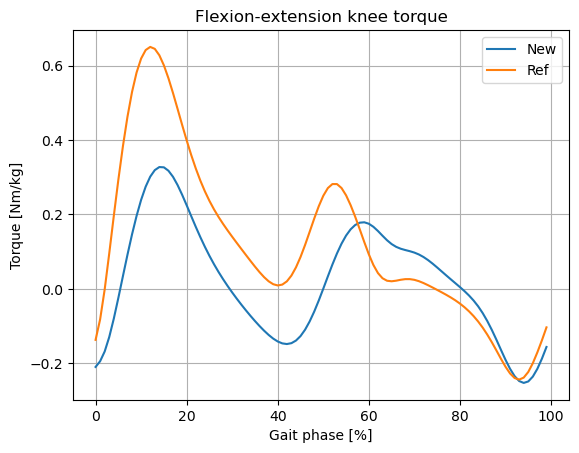



Pearson correlation coefficient for the hip torque: 0.8524


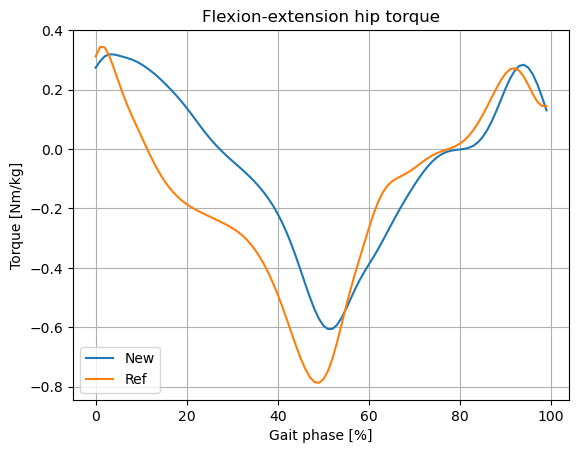

In [15]:
# Correlations and comparative plot, torques
%matplotlib inline
x_axis = np.linspace(0, 100, num=100, endpoint=False)

ankle_torque_corr = np.corrcoef(ankle_torque, y=ankle_torque_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the ankle torque: {ankle_torque_corr[0, 1]:.4g}")
plt.figure()
plt.title("Flexion-extension ankle torque")
plt.plot(x_axis, ankle_torque, label="New")
plt.plot(x_axis, ankle_torque_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Torque [Nm/kg]")
plt.legend()
plt.grid()
plt.show()

knee_torque_corr = np.corrcoef(knee_torque, y=knee_torque_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the knee torque: {knee_torque_corr[0, 1]:.4g}")
plt.figure()
plt.title("Flexion-extension knee torque")
plt.plot(x_axis, knee_torque, label="New")
plt.plot(x_axis, knee_torque_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Torque [Nm/kg]")
plt.legend()
plt.grid()
plt.show()

hip_torque_corr = np.corrcoef(hip_torque, y=hip_torque_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the hip torque: {hip_torque_corr[0, 1]:.4g}")
plt.figure()
plt.title("Flexion-extension hip torque")
plt.plot(x_axis, hip_torque, label="New")
plt.plot(x_axis, hip_torque_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Torque [Nm/kg]")
plt.legend()
plt.grid()
plt.show()



Pearson correlation coefficient for the x component of the GRF: 0.9426


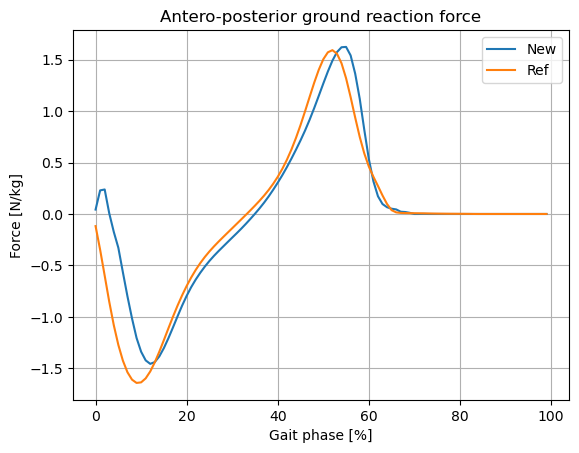



Pearson correlation coefficient for the y component of the GRF: 0.8934


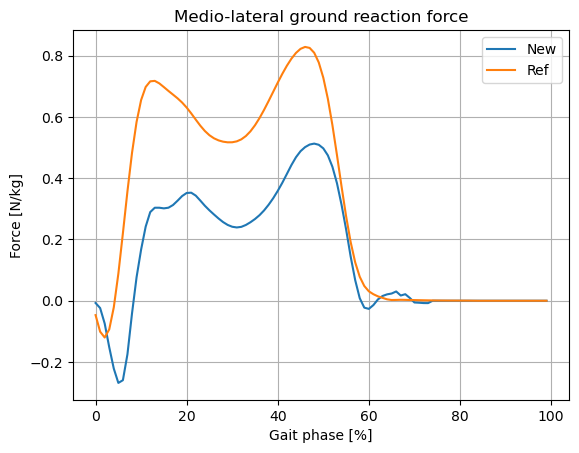



Pearson correlation coefficient for the z component of the GRF: 0.9762


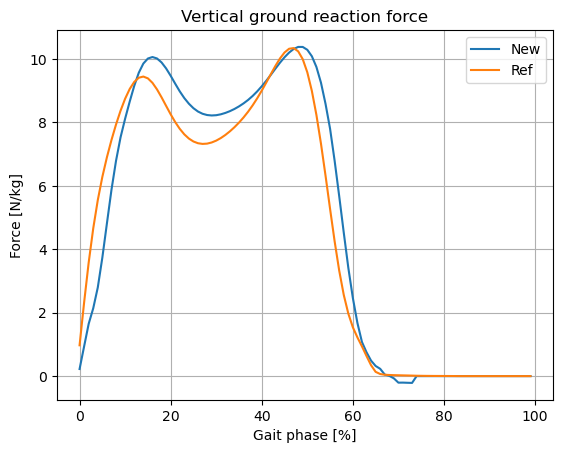

In [16]:
# Correlations and comparative plot, GRFs
%matplotlib inline
x_axis = np.linspace(0, 100, num=100, endpoint=False)

grf_x_corr = np.corrcoef(grf_x, y=grf_x_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the x component of the GRF: {grf_x_corr[0, 1]:.4g}")
plt.figure()
plt.title("Antero-posterior ground reaction force")
plt.plot(x_axis, grf_x, label="New")
plt.plot(x_axis, grf_x_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Force [N/kg]")
plt.legend()
plt.grid()
plt.show()

grf_y_corr = np.corrcoef(grf_y, y=grf_y_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the y component of the GRF: {grf_y_corr[0, 1]:.4g}")
plt.figure()
plt.title("Medio-lateral ground reaction force")
plt.plot(x_axis, grf_y, label="New")
plt.plot(x_axis, grf_y_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Force [N/kg]")
plt.legend()
plt.grid()
plt.show()

grf_z_corr = np.corrcoef(grf_z, y=grf_z_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the z component of the GRF: {grf_z_corr[0, 1]:.4g}")
plt.figure()
plt.title("Vertical ground reaction force")
plt.plot(x_axis, grf_z, label="New")
plt.plot(x_axis, grf_z_ref_rs/70, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Force [N/kg]")
plt.legend()
plt.grid()
plt.show()



Pearson correlation coefficient for the tibialis anterior EMG: 0.7826


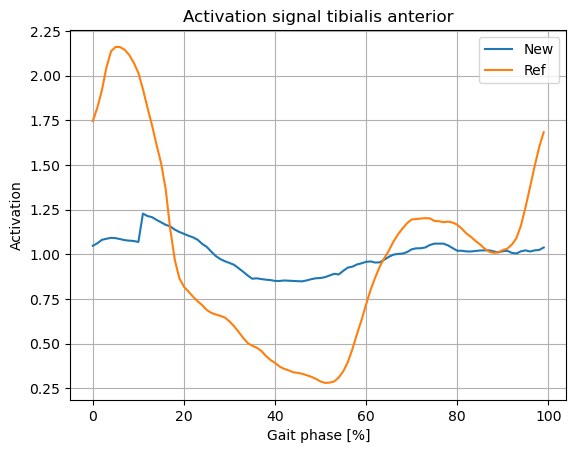



Pearson correlation coefficient for the gastrocnemius lateralis EMG: 0.7247


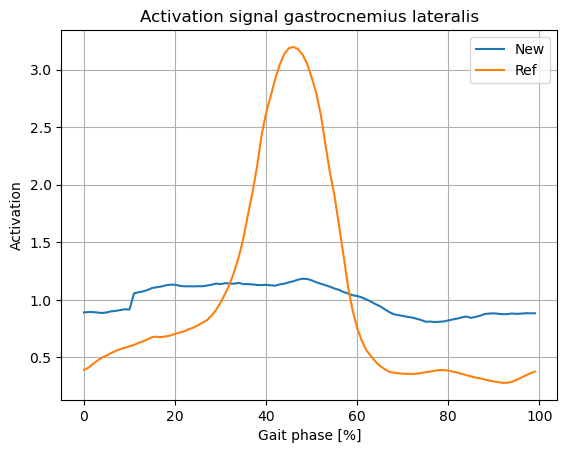



Pearson correlation coefficient for the vastus lateralis EMG: 0.9725


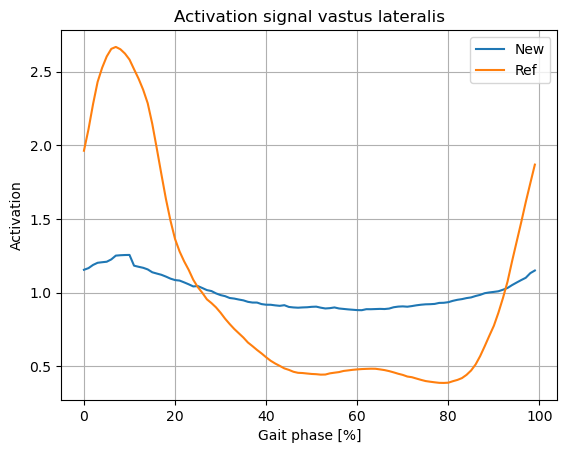



Pearson correlation coefficient for the biceps femoris EMG: 0.6489


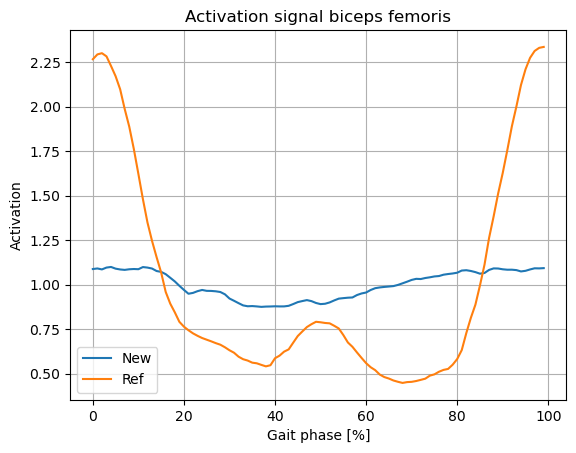

In [27]:
# Correlations and comparative plot, EMGs
%matplotlib inline
x_axis = np.linspace(0, 100, num=100, endpoint=False)

emg_ta = emg_ta/np.mean(emg_ta) # Does not affect correlation, just a scaling for nicer plots
emg_ta_del = np.roll(emg_ta, 11) # Does affect the correlation, their window is probably centered around the plotted point, whereas here the window runs from 300 ms back up to the plotted point
emg_ta_ref_rs = emg_ta_ref_rs/np.mean(emg_ta_ref_rs)

emg_ta_corr = np.corrcoef(emg_ta_del, y=emg_ta_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the tibialis anterior EMG: {emg_ta_corr[0, 1]:.4g}")
plt.figure()
plt.title("Activation signal tibialis anterior")
plt.plot(x_axis, emg_ta_del, label="New")
plt.plot(x_axis, emg_ta_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Activation")
plt.legend()
plt.grid()
plt.show()

emg_gl = emg_gl/np.mean(emg_gl)
emg_gl_del = np.roll(emg_gl, 11)
emg_gl_ref_rs = emg_gl_ref_rs/np.mean(emg_gl_ref_rs)

emg_gl_corr = np.corrcoef(emg_gl_del, y=emg_gl_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the gastrocnemius lateralis EMG: {emg_gl_corr[0, 1]:.4g}")
plt.figure()
plt.title("Activation signal gastrocnemius lateralis")
plt.plot(x_axis, emg_gl_del, label="New")
plt.plot(x_axis, emg_gl_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Activation")
plt.legend()
plt.grid()
plt.show()

emg_vl = emg_vl/np.mean(emg_vl)
emg_vl_del = np.roll(emg_vl, 11)
emg_vl_ref_rs = emg_vl_ref_rs/np.mean(emg_vl_ref_rs)

emg_vl_corr = np.corrcoef(emg_vl_del, y=emg_vl_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the vastus lateralis EMG: {emg_vl_corr[0, 1]:.4g}")
plt.figure()
plt.title("Activation signal vastus lateralis")
plt.plot(x_axis, emg_vl_del, label="New")
plt.plot(x_axis, emg_vl_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Activation")
plt.legend()
plt.grid()
plt.show()

emg_bf = emg_bf/np.mean(emg_bf)
emg_bf_del = np.roll(emg_bf, 11)
emg_bf_ref_rs = emg_bf_ref_rs/np.mean(emg_bf_ref_rs)

emg_bf_corr = np.corrcoef(emg_bf_del, y=emg_bf_ref_rs, rowvar=False)
print("\n")
print(f"Pearson correlation coefficient for the biceps femoris EMG: {emg_bf_corr[0, 1]:.4g}")
plt.figure()
plt.title("Activation signal biceps femoris")
plt.plot(x_axis, emg_bf_del, label="New")
plt.plot(x_axis, emg_bf_ref_rs, label="Ref")
plt.xlabel("Gait phase [%]")
plt.ylabel("Activation")
plt.legend()
plt.grid()
plt.show()